In [1]:
from functools import reduce
from pathlib import Path
from collections import Counter
from dataclasses import dataclass

from fastai.basic_train import get_preds, LearnerCallback, Learner
from fastai.text import *
from fastai.datasets import *
from fastai.metrics import *
from fastai.train import *
from fastai.vision import *
from fastai.callback import Callback
from fastai.callbacks import SaveModelCallback
import pandas as pd

from fastai.imports import nn, torch
from sklearn import metrics
import sklearn.metrics
import altair as alt

import news_utils

%load_ext autoreload
%autoreload 2

alt.renderers.enable('notebook')
torch.cuda.set_device(0)

In [2]:
EX_PA = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/sentiment_maj/')
MODELS = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_models/')
LM_DATA_PATH = Path('/mnt/data/group07/johannes/ynacc_proc/clean_split/lm_data/')

tokenizer = Tokenizer(special_cases = ['xxbos','xxfld','xxunk','xxpad', 'xxsep'])
# tokenizer = None

data_lm_train = pd.read_csv(LM_DATA_PATH/'train.csv')
data_lm_val = pd.read_csv(LM_DATA_PATH/'val.csv')

# Language model data
data_lm = TextLMDataBunch.from_df(LM_DATA_PATH, data_lm_train, data_lm_val, tokenizer=tokenizer)

In [3]:
new_itos = data_lm.train_ds.vocab.itos + ['xxstart', 'xxsep', 'xxend']

new_vocab = Vocab(new_itos)

In [4]:
data_clas_train = pd.read_csv(EX_PA/'train.csv')
data_clas_val = pd.read_csv(EX_PA/'val.csv')
data_clas_train["combined"] = "xxstart " + data_clas_train["headline"].map(str) + " xxsep " + data_clas_train["text"] + " xxend"
data_clas_val["combined"] = "xxstart " + data_clas_val["headline"].map(str) + " xxsep " + data_clas_val["text"] + " xxend"

data_clas_train

,class,text,url,headline,timestamp,combined
0,0.0,Maybe they should sell him off....make good pi...,http://qz.com/675490/cash-strapped-zimbabwe-se...,Cash-strapped Zimbabwe sells off its wildlife ...,1462446214,xxstart Cash-strapped Zimbabwe sells off its w...
1,0.0,We are building nuclear powered aircraft carri...,http://www.digitaltrends.com/cool-tech/china-f...,China is building floating nuclear power stations,1461464748,xxstart China is building floating nuclear pow...
2,0.0,"Ya, I always wonder why the conservatives are ...",http://mic.com/articles/142323/this-old-navy-a...,This Old Navy Ad Featuring an Interracial Fami...,1462204643,xxstart This Old Navy Ad Featuring an Interrac...
3,0.0,So they would be able to go back to their old ...,http://mic.com/articles/139674/nevada-inmate-f...,Nevada Inmate Forced to Rip His Own Teeth Out ...,1459723580,xxstart Nevada Inmate Forced to Rip His Own Te...
4,0.0,wake up! it's every government under the sun,http://mashable.com/2016/04/12/chinese-man-nak...,Chinese man lies naked under car to demand com...,1460471375,xxstart Chinese man lies naked under car to de...
5,0.0,So in response to bigotry you display somw of ...,http://mic.com/articles/140983/patrons-tipped-...,Patrons Tipped North Carolina Waitress With an...,1460848505,xxstart Patrons Tipped North Carolina Waitress...
6,0.0,And only brain dead parasites support Hillary ...,http://ap-org253133660-yahoopartner.tumblr.com...,AP-GfK Poll: Clinton has edge over Trump on ra...,1460411689,xxstart AP-GfK Poll: Clinton has edge over Tru...
7,2.0,"Ummm, You watch animals breastfeeding? For why...",http://mic.com/articles/139975/this-mother-did...,This Mother Did a Photoshoot Breastfeeding Her...,1459914224,xxstart This Mother Did a Photoshoot Breastfee...
8,1.0,"Sadly, I couldn't agree more. :/",http://www.goodhousekeeping.com/life/parenting...,When My Young Daughter Asked If God Is Just a ...,1461988445,xxstart When My Young Daughter Asked If God Is...
9,1.0,"According to the Press, Brown was denied a **p...",http://mic.com/articles/141141/patrick-brown-j...,"Patrick Brown, Jailed Because He Could Not Aff...",1461092908,"xxstart Patrick Brown, Jailed Because He Could..."


In [5]:
data_clas = news_utils.RandomSampler.TextClasDataBunchRandom.from_df(EX_PA, data_clas_train, data_clas_val, vocab=new_vocab, bs=50, txt_cols=['combined'], label_cols=['class'], num_samples=2000)

In [26]:
learn = language_model_learner(data_lm, pretrained_fnames=['lstm_wt103', 'itos_wt103'], drop_mult=0.5)

In [27]:
learn.fit_one_cycle(1, 1e-2)

Total time: 05:28
epoch  train_loss  valid_loss  accuracy
1      4.702953    4.542753    0.238456  (05:28)



In [28]:
# learn.load_encoder(MODELS/'ft_enc_05_30')
learn.unfreeze()
learn.fit_one_cycle(, 1e-3)

Total time: 06:23
epoch  train_loss  valid_loss  accuracy
1      4.388505    4.368560    0.254820  (06:23)



In [29]:
learn.save_encoder(MODELS/'06_11-_18')

In [3]:
# weights = [1,1, 1, 1]
# class_weights = torch.FloatTensor(weights).cuda()
# loss_func = nn.CrossEntropyLoss(weight=class_weights)

In [6]:
old_weights = torch.load(MODELS/'ft_enc_05_30_continued.pth')

enc_weights = old_weights['encoder.weight']

old_weights['encoder.weight'] = torch.cat([enc_weights, torch.rand(3, 400).cuda()], 0)

old_weights['encoder_dp.emb.weight'] = torch.cat([old_weights['encoder_dp.emb.weight'], torch.rand(3, 400).cuda()], 0)

In [13]:
# learn2 = text_classifier_learner(data_clas, drop_mult=1)
# learn2.model[0].load_state_dict(old_weights)

In [10]:
learn2 = text_classifier_learner(data_clas, drop_mult=0)
learn2.model[0].load_state_dict(old_weights)
# learn2.load_encoder(MODELS/'ft_enc_05_30_continued')

# F1 score and save only best f1 macro score
@dataclass
class F1Macro(Callback):
    name:str='F1_macro'
    
    def on_epoch_begin(self, **kwargs):
        self.y_pred, self.y_true = [], []
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        _, idxs = torch.max(last_output, 1)
        self.y_pred += idxs.tolist()
        self.y_true += last_target.tolist()
    
    
    def on_epoch_end(self, **kwargs):
        f1_macro = sklearn.metrics.f1_score(self.y_pred, self.y_true, average='macro')
        self.metric = f1_macro

        
learn2.metrics = [F1Macro()]

# learn2.callbacks += [SaveModelCallback(learn2, 'F1_macro', 'max', name='getreal1k_combined2')]

learn2.fit(1000, 1e-5)

Total time: 2:21:17
epoch  train_loss  valid_loss  F1_macro
1      1.388016    1.432985    0.217495  (00:09)
2      1.372802    1.430834    0.236738  (00:08)
3      1.347113    1.431901    0.226061  (00:09)
4      1.337667    1.423264    0.241498  (00:09)
5      1.334925    1.383225    0.259315  (00:09)
6      1.302954    1.393372    0.275875  (00:07)
7      1.299527    1.370131    0.277479  (00:08)
8      1.291057    1.373342    0.281238  (00:07)
9      1.273543    1.338980    0.295795  (00:08)
10     1.267687    1.353157    0.304213  (00:08)
11     1.259093    1.335259    0.293628  (00:09)
12     1.251463    1.331138    0.283197  (00:08)
13     1.238868    1.316646    0.310977  (00:09)
14     1.226152    1.325559    0.299800  (00:07)
15     1.226613    1.321838    0.320181  (00:08)
16     1.206475    1.343608    0.302257  (00:09)
17     1.209909    1.318457    0.313640  (00:09)
18     1.207795    1.327853    0.300593  (00:08)
19     1.198302    1.312485    0.320929  (00:07)
20     1.

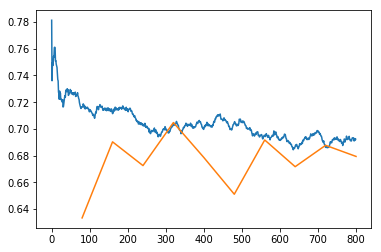

In [12]:
learn2.recorder.plot_losses()

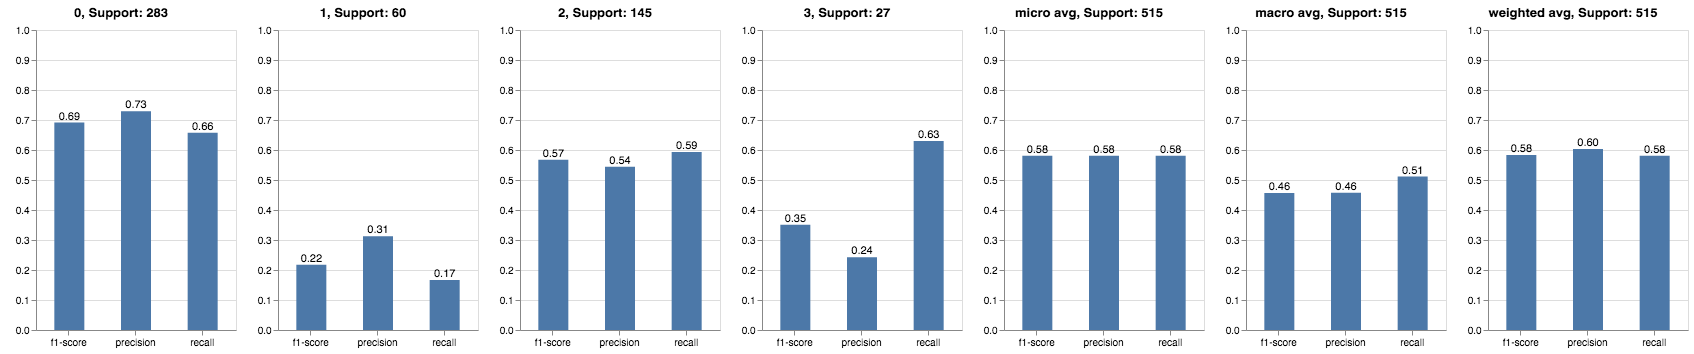

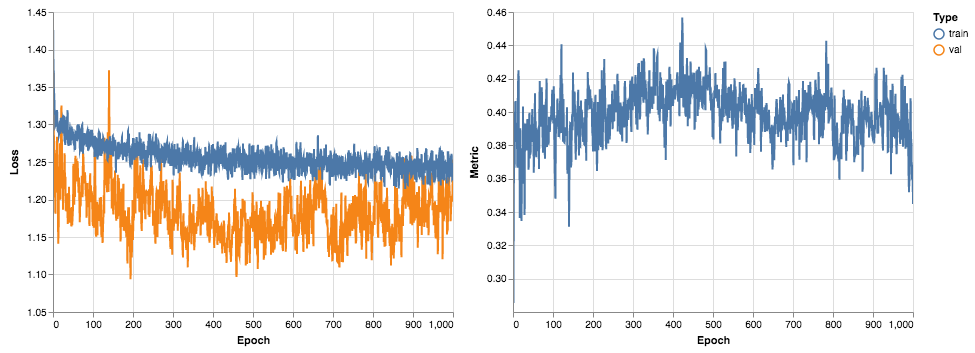

SankeyWidget(links=[{'source': 'true negative', 'target': 'pred negative', 'type': 'cor', 'value': 186}, {'sou…

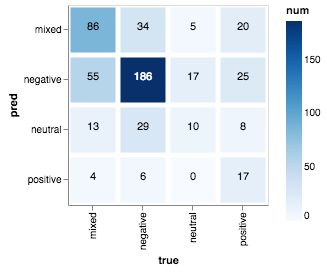

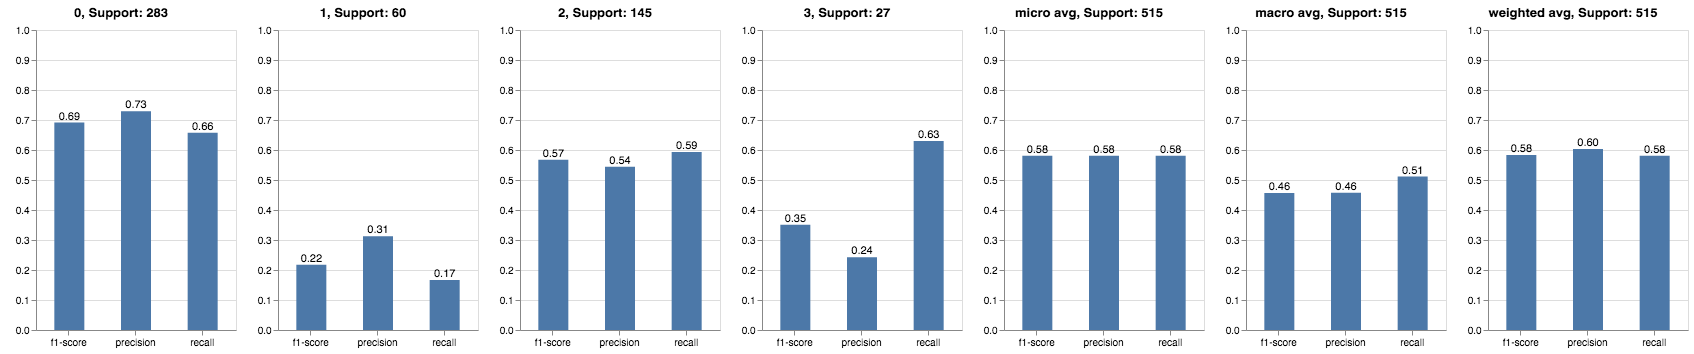

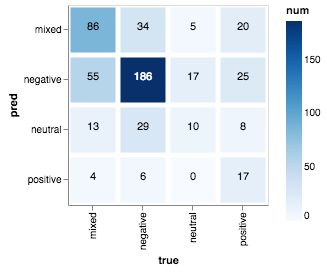

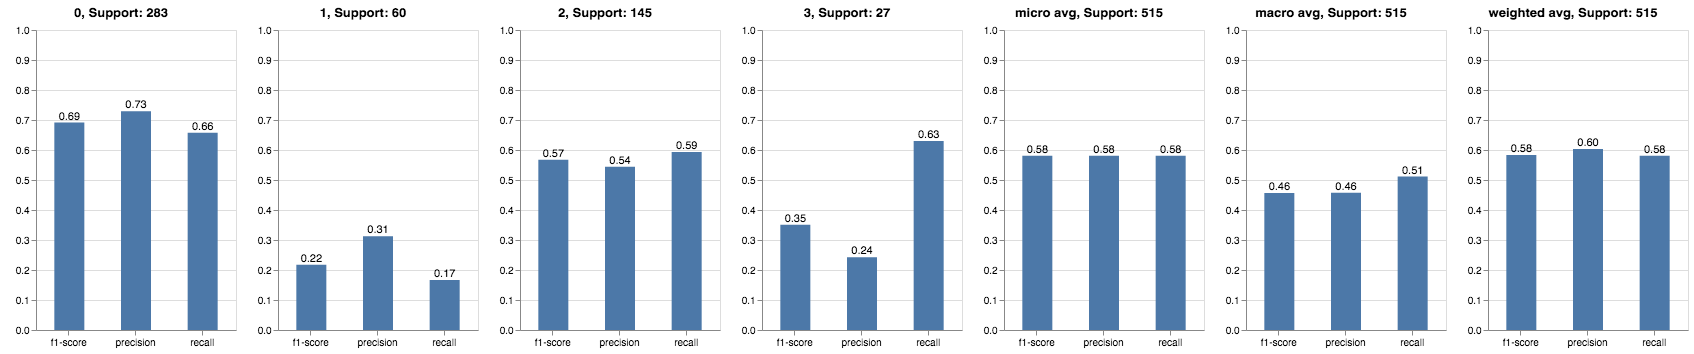

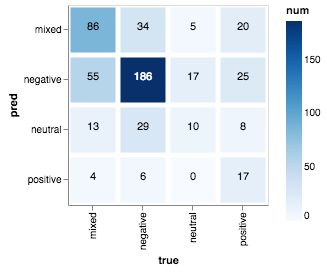

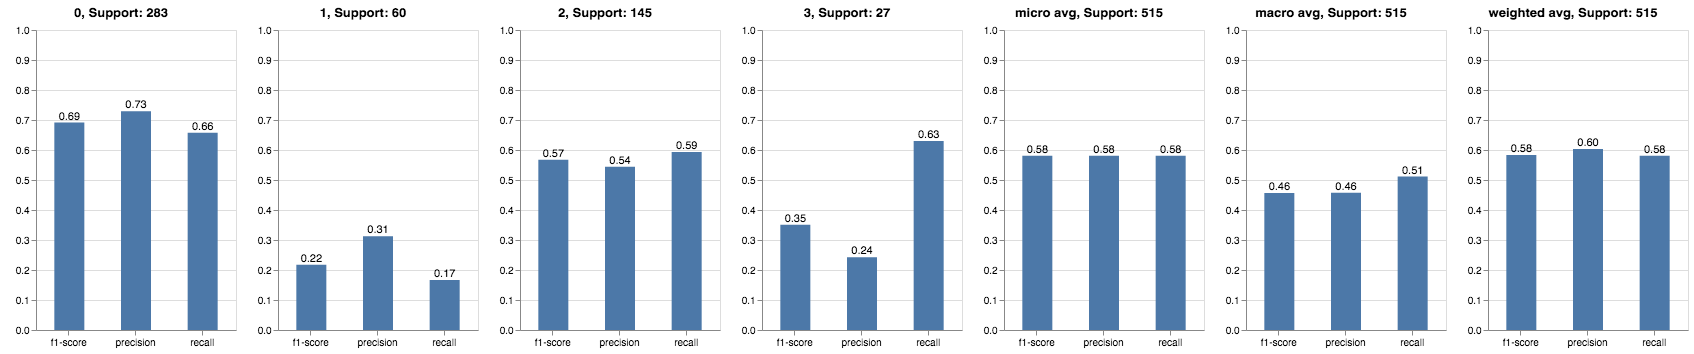

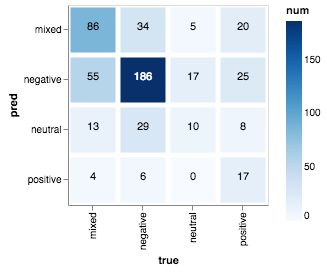

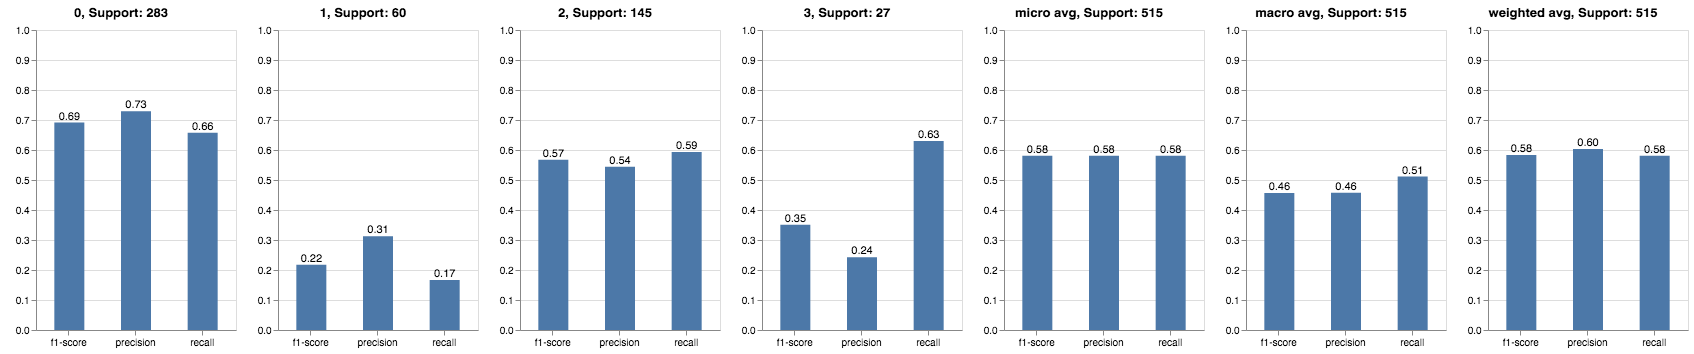

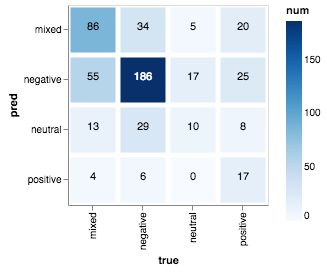

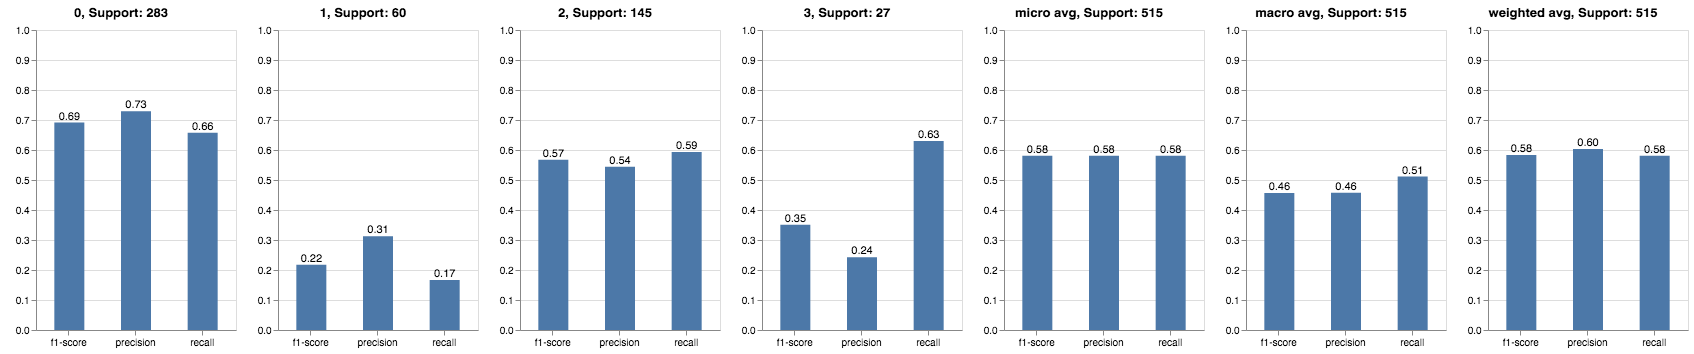

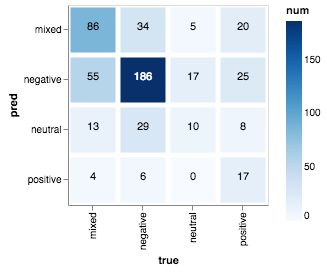

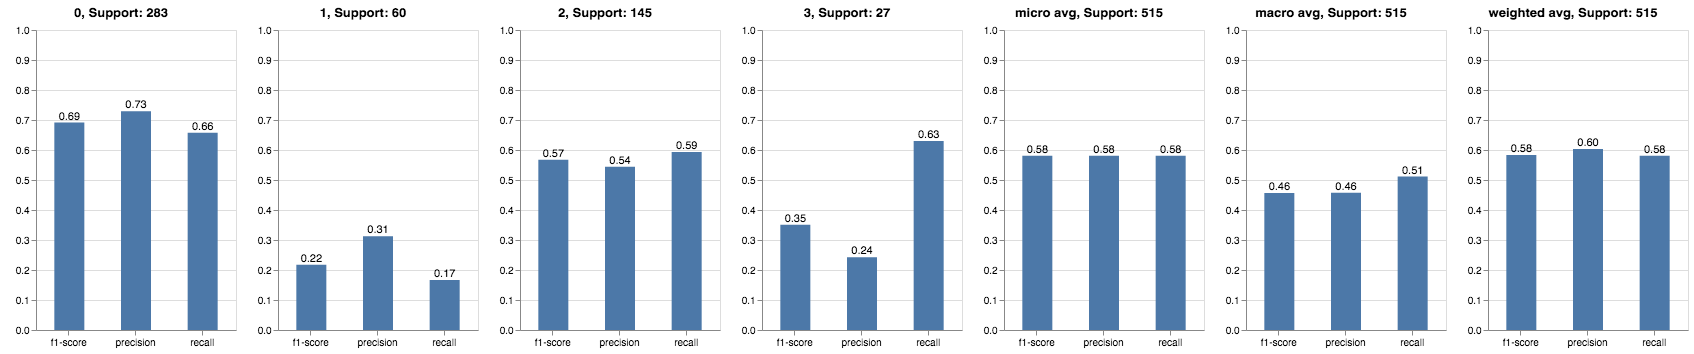

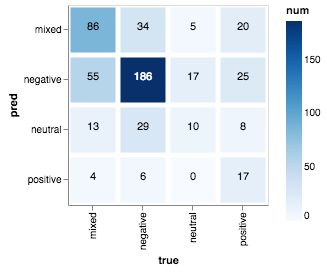

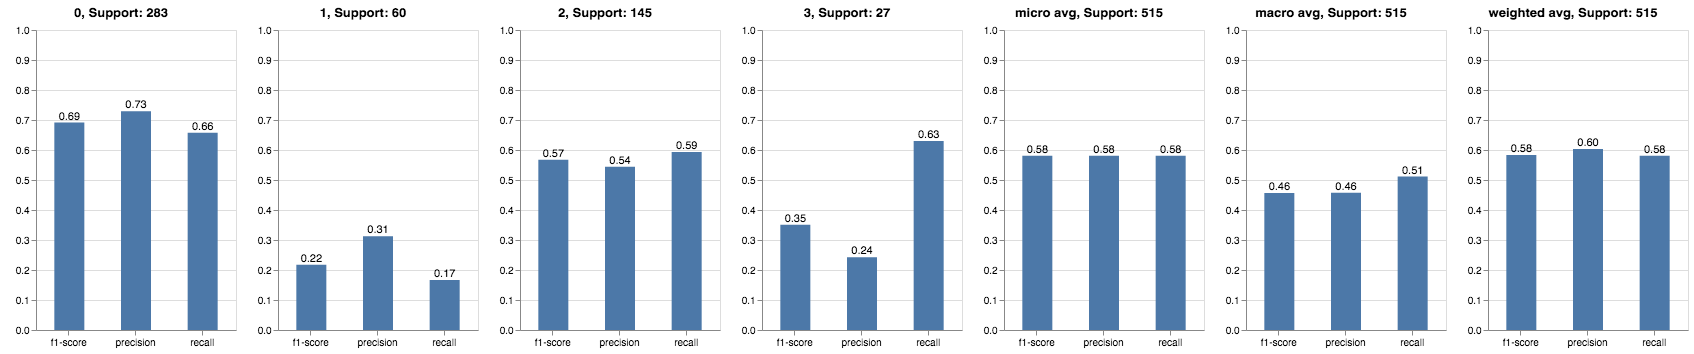

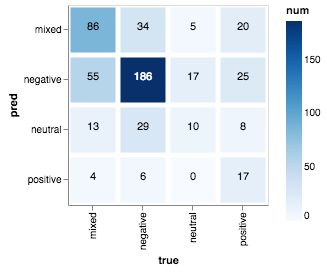

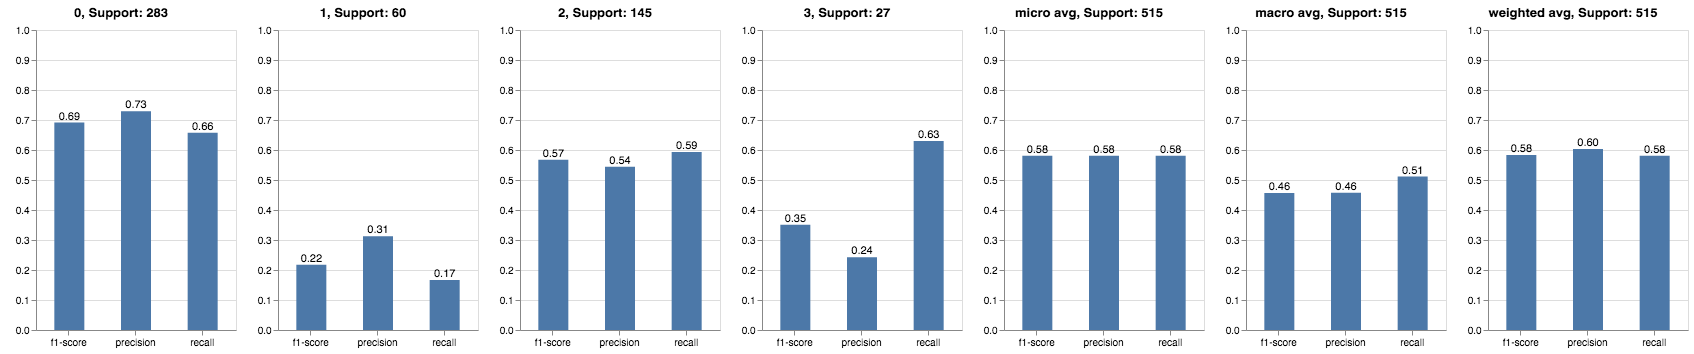

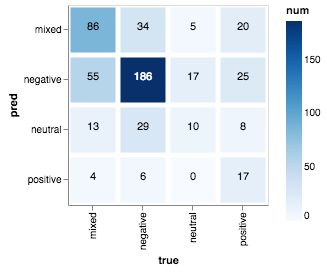

In [17]:
news_utils.plot.all(learn2, labels=['negative', 'neutral', 'mixed', 'positive'])

In [62]:
learn3 = text_classifier_learner(data_clas, drop_mult=1)
learn3.load('getreal1k')
learn3.metrics = [F1Macro()]
learn3.callbacks += [SaveModelCallback(learn3, 'F1_macro', 'max', name='getreal1k_2_2')]

In [ ]:
learn3.freeze_to(-2)
learn3.fit(100, slice(1e-5/2, 1e-5))

epoch,train_loss,valid_loss,F1_macro
1,1.243046,1.144025,0.429561
2,1.234400,1.155096,0.437786
3,1.255607,1.166967,0.440783
4,1.225963,1.161678,0.411633
5,1.220841,1.153277,0.423021
6,1.237482,1.134307,0.433512
7,1.238692,1.150320,0.447011
8,1.243704,1.160760,0.453158
9,1.259443,1.153121,0.444342
10,1.264287,1.138414,0.439587
